# Sanity check FLCT vs Stein simulation vs HMI data

In [117]:
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.io import readsav
import glob
import fitsio
from scipy.signal import convolve2d
from scipy.ndimage.filters import gaussian_filter 

mpl.rcParams['font.size'] = 20
mpl.rcParams['legend.fontsize'] = 'medium'
mpl.rcParams['figure.titlesize'] = 'medium'
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14

In [146]:
def read_vel(file, data_str):
    idl_dict = readsav(file)
    vel = idl_dict[data_str]
    return vel

def load_vel_mean(v_files, trange):
    "Load the velocity files and average over a time range"
    vxs = []
    vys = []
    vx_files_subset = v_files[0][trange[0]:trange[1]]
    vy_files_subset = v_files[1][trange[0]:trange[1]]
    for vxf, vyf in zip(vx_files_subset, vy_files_subset):
        vxs.append(fitsio.read(vxf))
        vys.append(fitsio.read(vyf))
    # Get the mean of the velocity components
    vx = np.array(vxs).mean(axis=0)
    vy = np.array(vys).mean(axis=0)
    return vx, vy


def fit_drift(x, y):
    A = np.vstack([x, np.ones(len(x))]).T
    fit = np.linalg.lstsq(A, y, rcond=None)
    m, c = fit[0]
    res = fit[1]
    print('bias velocity =', c, 'm/s')
    vfit = m*x + c
    return vfit, res


datadir = '/Users/rattie/Data/sanity_check/'
karin_dir = '/Users/rattie/Data/Karin/sanity_check/'

rsun_obs=953.288 # arcsec
# SDO resolution
# Arcsec/pix
cdelt1=0.504365
# R -> m
rsun_ref=6.96000e8
# R -> km
rkm=rsun_ref/1000.0
# R -> pixel
rsun=round(rsun_obs/cdelt1)
# Nb. m / pix
deltas = rkm*1e3/rsun_obs*cdelt1
print(deltas)
unit = deltas/60
unit2 = deltas / 45 # m/s

# Select a subfield excluding edge effects
imsize = 263 # actual size is 264 but original size was 263 then padded to 264 to make it even for the Fourier transform
# Use same padding size as in Tremblay et al. 2018 used pad = 10
pad = 10
fov = np.s_[pad:imsize - pad, pad:imsize-pad]
fwhm = 7

# Drift parameters
dv = 0.04
vx_rates = np.arange(-0.2, 0.21, dv)
vx_rates[int(len(vx_rates)/2)] = 0
vx_ratesu = vx_rates*unit
vx_ratesu2 = vx_rates*unit2
print(vx_rates)
print(vx_ratesu.round())
print(vx_ratesu2.round())
# padding for hmi
pad2 = 24

# Load true Stein velocity
data_dir_stein = '/Users/rattie/Data/Ben/SteinSDO/'
svx_files = sorted(glob.glob(os.path.join(data_dir_stein,'SDO_vx*.fits')))
svy_files = sorted(glob.glob(os.path.join(data_dir_stein,'SDO_vy*.fits')))
trange = [0,29]
vx_stein, vy_stein = load_vel_mean((svx_files, svy_files), trange)

# Get true mean velocity (unit already in m/s)
vx_stein_mean = vx_stein[fov].mean()
print(vx_stein_mean, 'm/s')

368239.23095643707
[-0.2  -0.16 -0.12 -0.08 -0.04  0.    0.04  0.08  0.12  0.16  0.2 ]
[-1227.  -982.  -736.  -491.  -245.     0.   245.   491.   736.   982.
  1227.]
[-1637. -1309.  -982.  -655.  -327.     0.   327.   655.   982.  1309.
  1637.]
-90.40378 m/s


### FLCT on drifted Stein series

In [125]:
flctfiles_stein_vx = sorted(glob.glob(os.path.join('/Users/rattie/Data/sanity_check/stein_series_FLCT_106/output_FLCT_sigma7', 
                                                         'drift_unfiltered_*/FLCT_vx1_000-028.fits')))
flctfiles_stein_vx2 = sorted(glob.glob(os.path.join('/Users/rattie/Data/sanity_check/stein_series_FLCT_106/output_FLCT_sigma7_bias_correction', 
                                                         'drift_unfiltered_*/FLCT_vx1_000-028.fits')))

vxs_flct_stein = [fitsio.read(f) for f in flctfiles_stein_vx]
vxs_flct_stein2 = [fitsio.read(f) for f in flctfiles_stein_vx2]
# Average FLCT on stein with time range of 30 min. 29 frames for Stein data - concert to m/s
vxsmean_flct_stein = np.array([vx[pad2:-pad2,pad2:-pad2].mean()*unit - vx_stein_mean for vx in vxs_flct_stein])
vxsmean_flct_stein2 = np.array([vx[pad2:-pad2,pad2:-pad2].mean()*unit - vx_stein_mean for vx in vxs_flct_stein2])
# Fit drifted data
vxfit_stein1, res_stein1 = fit_drift(vxsmean_flct_stein, vx_ratesu)
vxfit_stein2, res_stein2 = fit_drift(vxsmean_flct_stein2, vx_ratesu)


bias velocity = -38.51630821034709 m/s
bias velocity = -35.58117178808489 m/s


5.8396167473144525
5.9107725682449965


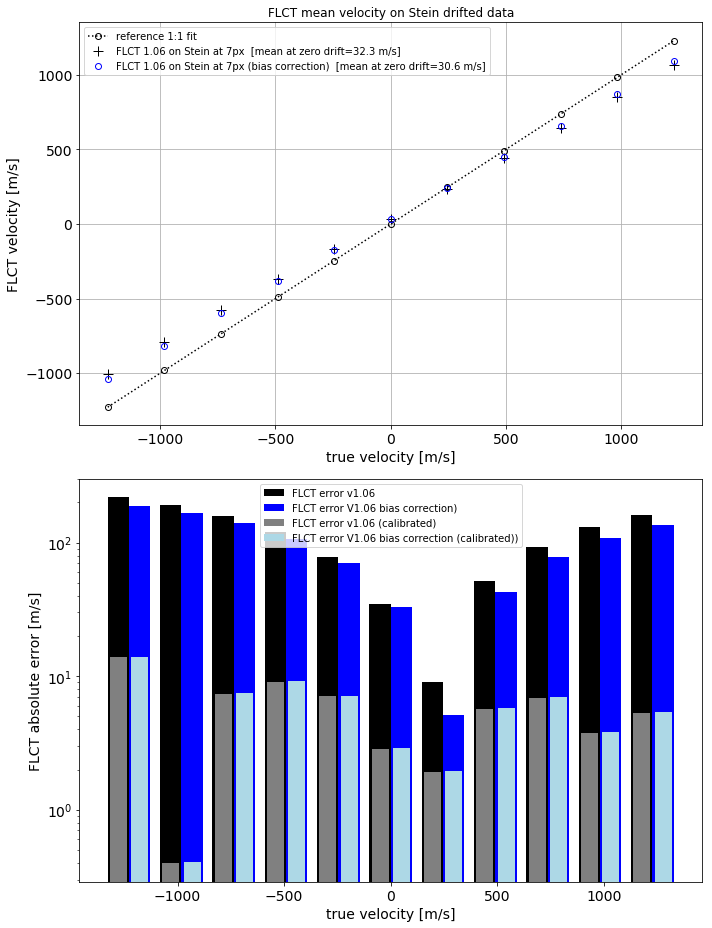

In [141]:
%matplotlib inline
fig, ax = plt.subplots(2,1, figsize = (10,13))
ax[0].plot(vx_ratesu, vx_ratesu, 'k-', ls=':', marker='o', markerfacecolor='none', label='reference 1:1 fit')
ax[0].plot(vx_ratesu, vxsmean_flct_stein, ls='none', marker='+', ms=10, color='black', label = 'FLCT 1.06 on Stein at 7px  [mean at zero drift={:2.1f} m/s]'.format(vxsmean_flct_stein.mean()))
ax[0].plot(vx_ratesu, vxsmean_flct_stein2, ls='none', marker='o', color='blue', markerfacecolor='none', label = 'FLCT 1.06 on Stein at 7px (bias correction)  [mean at zero drift={:2.1f} m/s]'.format(vxsmean_flct_stein2.mean()))

ax[0].grid(True, axis='both')
ax[0].set_xlabel('true velocity [m/s]')
ax[0].set_ylabel('FLCT velocity [m/s]')
ax[0].legend()
ax[0].set_title('FLCT mean velocity on Stein drifted data')
# ax[0].text(0.1, 0.8,'test', transform=ax[0].transAxes)

res1_unfiltered = abs(vxsmean_flct_stein - vx_ratesu)
res2_unfiltered = abs(vxsmean_flct_stein2 - vx_ratesu)
res3_unfiltered = abs(vxsmean_flct_stein2 - vxsmean_flct_stein)

res1_drift = abs(vxfit_stein1 - vx_ratesu)
res2_drift = abs(vxfit_stein2 - vx_ratesu)
print(res1_drift.mean())
print(res2_drift.mean())

# width of the bars 
bw = 100
ax[1].bar(vx_ratesu-bw/2, res1_unfiltered, bw, color='black', label='FLCT error v1.06')
ax[1].bar(vx_ratesu+bw/2, res2_unfiltered, bw, color='blue', label='FLCT error V1.06 bias correction)')

ax[1].bar(vx_ratesu-bw/2, res1_drift, 0.8*bw, color='gray', label='FLCT error v1.06 (calibrated)')
ax[1].bar(vx_ratesu+bw/2, res2_drift, 0.8*bw, color='lightblue', label='FLCT error V1.06 bias correction (calibrated))')
#ax[1].bar(vx_ratesu2+bw/2, res3_unfiltered, 0.6*bw, color='green', label='with vs withous bias correction')
ax[1].set_xlabel('true velocity [m/s]')
ax[1].set_ylabel('FLCT absolute error [m/s]')
ax[1].legend()
ax[1].set_yscale('log')
plt.tight_layout()
plt.savefig(os.path.join(datadir, 'figures/stein_sanity_check1.png'), dpi=150)


### FLCT on drifted HMI series

In [150]:
# FLCT results on unfiltered hmi
flctfiles_hmi_unfiltered_vx = sorted(glob.glob(os.path.join('/Users/rattie/Data/sanity_check/hmi_series_FLCT_106/output_FLCT_sigma7', 
                                                         'drift_unfiltered_*/FLCT_vx1_000-038.fits')))
flctfiles_hmi_unfiltered_vx2 = sorted(glob.glob(os.path.join('/Users/rattie/Data/sanity_check/hmi_series_FLCT_106/output_FLCT_sigma7_bias_correction', 
                                                         'drift_unfiltered_*/FLCT_vx1_000-038.fits')))
# Load unfiltered files 
vxs_flct_hmi_unfiltered = [fitsio.read(f) for f in flctfiles_hmi_unfiltered_vx]
vxs_flct_hmi_unfiltered2 = [fitsio.read(f) for f in flctfiles_hmi_unfiltered_vx2]

# Average FLCT on HMI with time range of 30 min. 39 frames for HMI - convert to m/s
vxsmean_flct_hmi_unfiltered = np.array([vx[pad2:-pad2,pad2:-pad2].mean()*unit2 for vx in vxs_flct_hmi_unfiltered])
vxsmean_flct_hmi_unfiltered2 = np.array([vx[pad2:-pad2,pad2:-pad2].mean()*unit2 for vx in vxs_flct_hmi_unfiltered2])
# Fit drifted data
vxfit1, res1 = fit_drift(vxsmean_flct_hmi_unfiltered, vx_ratesu2)
vxfit2, res2 = fit_drift(vxsmean_flct_hmi_unfiltered2, vx_ratesu2)

# FLCT results on filtered hmi (filtered by Karin)
flctfiles_hmi = sorted(glob.glob(os.path.join(karin_dir, 'hmi_series', 'flct-km*.save')))
vxs_flct_hmi = [read_vel(f, 'vx') for f in flctfiles_hmi]
vxsmean_flct_hmi = np.array([vx[0:39,pad2:-pad2,pad2:-pad2].mean(axis=0).mean()*unit2  for vx in vxs_flct_hmi])
vxfit3, res3 = fit_drift(vxsmean_flct_hmi, vx_ratesu2)

bias velocity = -19.773295720701306 m/s
bias velocity = -19.732251623191964 m/s
bias velocity = 11.645294683251112 m/s


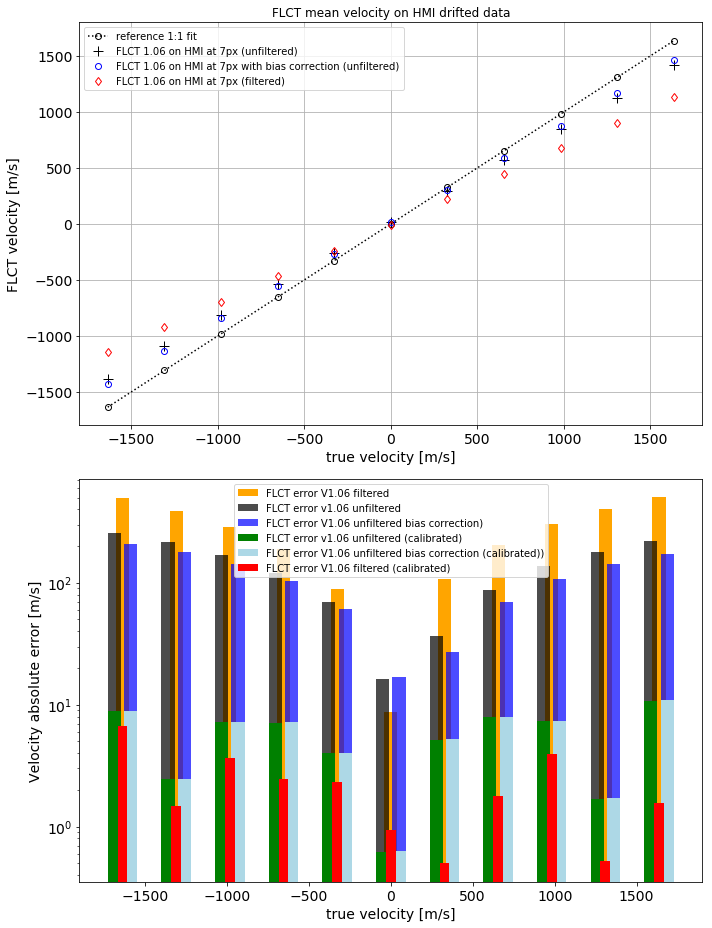

In [172]:
%matplotlib inline
fig, ax = plt.subplots(2,1, figsize = (10,13))
ax[0].plot(vx_ratesu2, vx_ratesu2, 'k-', ls=':', marker='o', markerfacecolor='none', label='reference 1:1 fit')
ax[0].plot(vx_ratesu2, vxsmean_flct_hmi_unfiltered, ls='none', marker='+', ms=10, color='black', label = 'FLCT 1.06 on HMI at 7px (unfiltered)')
ax[0].plot(vx_ratesu2, vxsmean_flct_hmi_unfiltered2, ls='none', marker='o', color='blue', markerfacecolor='none', label = 'FLCT 1.06 on HMI at 7px with bias correction (unfiltered)')
ax[0].plot(vx_ratesu2, vxsmean_flct_hmi, ls='none', marker='d', color='red', markerfacecolor='none', label = 'FLCT 1.06 on HMI at 7px (filtered) ')

ax[0].grid(True, axis='both')
ax[0].set_xlabel('true velocity [m/s]')
ax[0].set_ylabel('FLCT velocity [m/s]')
ax[0].legend()
ax[0].set_title('FLCT mean velocity on HMI drifted data')

res1_unfiltered = abs(vxsmean_flct_hmi_unfiltered - vx_ratesu2)
res2_unfiltered = abs(vxsmean_flct_hmi_unfiltered2 - vx_ratesu2)
res3_unfiltered = abs(vxsmean_flct_hmi - vx_ratesu2)

res1_drift = abs(vxfit1 - vx_ratesu2)
res2_drift = abs(vxfit2 - vx_ratesu2)
res3_drift = abs(vxfit3 - vx_ratesu2)


# width of the bars 
bw = 100

ax[1].bar(vx_ratesu2, res3_unfiltered, 0.8*bw, color='orange', label='FLCT error V1.06 filtered')
ax[1].bar(vx_ratesu2-bw/2, res1_unfiltered, 0.8*bw, color='black', label='FLCT error v1.06 unfiltered', alpha=0.7)
ax[1].bar(vx_ratesu2+bw/2, res2_unfiltered, 0.8*bw, color='blue', label='FLCT error V1.06 unfiltered bias correction)', alpha=0.7)

ax[1].bar(vx_ratesu2-bw/2, res1_drift, 0.8*bw, color='green', label='FLCT error v1.06 unfiltered (calibrated)')
ax[1].bar(vx_ratesu2+bw/2, res2_drift, 0.8*bw, color='lightblue', label='FLCT error V1.06 unfiltered bias correction (calibrated))')
ax[1].bar(vx_ratesu2, res3_drift, 0.6*bw, color='red', label='FLCT error V1.06 filtered (calibrated)')

ax[1].set_xlabel('true velocity [m/s]')
ax[1].set_ylabel('Velocity absolute error [m/s]')
ax[1].legend()
ax[1].set_yscale('log')
plt.tight_layout()
plt.savefig(os.path.join(datadir, 'figures/hmi_sanity_check1.png'), dpi=150)

#### Conclusion: With HMI and Stein simulation for unfiltered data, the bias corrections does not affect the scaling error. Once calibrated like with Balltracking, the bias corrections brings no improvement. 

## Correlation between velocites from FLCT and Stein MHD simulation (no drift)

In [174]:
def calc_c_pearson(vx1, vx2, vy1, vy2, fov=None):
    vx1f, vx2f, vy1f, vy2f = vx1[fov], vx2[fov], vy1[fov], vy2[fov]
    c_pearson = np.sum(vx1f*vx2f + vy1f*vy2f) / np.sqrt(np.sum(vx1f**2 + vy1f**2)*np.sum(vx2f**2 + vy2f**2))
    return c_pearson


def smooth_vel(vxs, vys, fwhm, kernel='boxcar'):
    """ Smooth the velocity with a smoothing kernel that can either be: 
     - boxcar: width set to fwhm
     - gaussian: parametrized by fwhm. 
     
     Returns the smoothed velocity components
    """ 
    
    if kernel == 'boxcar':
        box = np.ones([fwhm, fwhm])
        vxs2 = convolve2d(vxs, box, mode='same')
        vys2 = convolve2d(vys, box, mode='same')
    elif kernel == 'gaussian':
        sigma = fwhm / 2.35
        vxs2 = gaussian_filter(vxs, sigma=sigma, order=0)
        vys2 = gaussian_filter(vys, sigma=sigma, order=0)
        
    return vxs2, vys2


In [175]:
# smooth the Stein velocities 
vx_stein_sm, vy_stein_sm = smooth_vel(vx_stein, vy_stein, fwhm, kernel='boxcar') 

In [177]:
vx_flct = fitsio.read('/Users/rattie/Data/sanity_check/stein_series_FLCT_106/output_FLCT_sigma7', 
                                                         'drift_unfiltered_05/FLCT_vx1_000-028.fits')
vy_flct = fitsio.read('/Users/rattie/Data/sanity_check/stein_series_FLCT_106/output_FLCT_sigma7', 
                                                         'drift_unfiltered_05/FLCT_vy1_000-028.fits')


OSError: FITSIO status = 108: error reading from FITS file
Error reading data buffer from file:
/Users/rattie/Data/sanity_check/stein_series_FLCT_106/output_FLCT_sigma7
ffopen could not interpret primary array header of file: 
/Users/rattie/Data/sanity_check/stein_series_FLCT_106/output_FLCT_sigma7
